In [1]:
!git clone https://github.com/faisal9873/extend-ai-ml-assessment

fatal: destination path 'extend-ai-ml-assessment' already exists and is not an empty directory.


In [1]:
import numpy as np
import torch
import glob
import cv2
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import pickle
from matplotlib import pyplot as plt
from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from sklearn.metrics import accuracy_score
from scipy import ndimage
from tqdm import tqdm
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
images1 = [cv2.imread(file) for file in glob.glob('/content/drive/MyDrive/Colab Notebooks/extend_AI/data_grouped/unmarked/*.jpg')]
images2 = [cv2.imread(file) for file in glob.glob('/content/drive/MyDrive/Colab Notebooks/extend_AI/data_grouped/marked/*.jpg')]

#image resize
print(len(images1))
images1_resize = images1
images2_resize = images2
a = cv2.resize(images1[0],(128,128),interpolation=cv2.INTER_AREA)
for i in range (len(images1)):
  images1_resize[i] = cv2.resize(images1[i],(128,128),interpolation=cv2.INTER_AREA)
  images2_resize[i] = cv2.resize(images2[i],(128,128),interpolation=cv2.INTER_AREA)

images1_resize = (np.array(images1_resize))/255
images2_resize = (np.array(images2_resize))/255

no_images1 = images1_resize.shape [0]
y1 = np.zeros(no_images1) #unmarked

no_images2 = images2_resize.shape [0]
y2 = np.ones(no_images2) #marked

x_test = np.concatenate((images1_resize,images2_resize))
x_test =np.reshape(x_test, (x_test.shape[0],x_test.shape[3],x_test.shape[1],x_test.shape[2]))

y_test = np.concatenate((y1,y2))

In [5]:
x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test)
torch_images1 = torch.Tensor(images1_resize)
torch_images2 = torch.Tensor(images2_resize)

In [7]:
#data augmentation
final_train_data = []
final_target_train = []
angle = 0
NUM=40
for i in tqdm(range(torch_images1.shape[0])):
    #final_train_data.append(torch_images1[i])
  for k in range(NUM):
        final_train_data.append(rotate(torch_images1[i], angle=angle+5, mode = 'wrap'))
        final_train_data.append(random_noise(torch_images1[i],var=0.2**2*NUM/10))
  
  for j in range(2*NUM):
        final_target_train.append(y1[i])
angle = 0
for i in tqdm(range(torch_images2.shape[0])):
  for k in range(NUM):
    final_train_data.append(rotate(torch_images2[i], angle=angle+5, mode = 'wrap'))
    final_train_data.append(random_noise(torch_images2[i],var=0.2**2*NUM/10))

  for j in range(2*NUM):
    final_target_train.append(y2[i])

x_train =np.array((final_train_data))
#plt.imshow(final_train_data[500])
x_train =np.reshape(x_train, (x_train.shape[0],x_train.shape[3],x_train.shape[1],x_train.shape[2]))
y_train =np.array((final_target_train))
#print(x_train.shape)
#print(y_train.shape)

x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train) #arget.long()
x_train = x_train.float()
y_train = y_train.float()

x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test)
x_test = x_test.float()
y_test = y_test.float()

#print(x_train.shape)
##print(y_train.shape)
#print(x_test.shape)    
#x_train[3]

100%|██████████| 4/4 [00:00<00:00,  5.18it/s]


In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 128, 3)
        self.conv5 = nn.Conv2d(128, 256, 3)
        self.conv6 = nn.Conv2d(256, 128, 3)
        #self.conv5 = nn.Conv2d(64, 16, 3)
        self.fc1 = nn.Linear(80000, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1) #self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        #x = self.pool(F.relu(self.conv5(x)))
        x = F.relu(self.conv6(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.sigmoid(x) #x


model = Net()
if torch.cuda.is_available():
    model.cuda()

In [10]:
import torch.optim as optim #do not run this cell more than once

y_train = y_train.unsqueeze(1)
y_test = y_test.unsqueeze(1)
y_train = y_train.float()
y_test = y_test.float()

criterion = nn.BCELoss() #nn.CrossEntropyLoss() #nn.BCEWithLogitsLoss()# nn.BCELoss() #nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.004, momentum=0.9) #changed lr from 0.001
optimizer = optim.Adam(model.parameters(), lr=0.0001) #changed lr from 0.001

print(model)


Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=80000, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)


In [ ]:
import torch.optim as optim #if you want to rerun the above cell again, you can run this one instead

y_train = y_train.float()
y_test = y_test.float()

criterion = nn.BCELoss() #nn.CrossEntropyLoss() #nn.BCEWithLogitsLoss()# nn.BCELoss() #nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.004, momentum=0.9) #changed lr from 0.001
optimizer = optim.Adam(model.parameters(), lr=0.0001) #changed lr from 0.001

print(model)


In [13]:
t = torch.arange(y_train.shape[0]) 
np.random.shuffle(t.numpy())
#print(t)  
x_train_shuffle = x_train[t]
y_train_shuffle = y_train[t]
#len(y_train_shuffle)

In [ ]:
torch.manual_seed(0)
training_loss1 = []
# batch size of the model
batch_size = 64

# number of epochs to train the model
n_epochs = 100

for epoch in range(1, n_epochs+1):

    train_loss = 0.0
        
    permutation = torch.randperm(x_train.size()[0])

    training_loss = []
    
    for i in tqdm(range(0,x_train.size()[0], batch_size)):

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train_shuffle[indices], y_train_shuffle[indices].type(torch.float) #changed long to float
        
        if torch.cuda.is_available():
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        #print(outputs)
        loss = criterion(outputs,batch_y)

        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    training_loss = np.average(training_loss)
    training_loss1.append(training_loss)
    print('epoch: \t', epoch, '\t training loss: \t', training_loss)


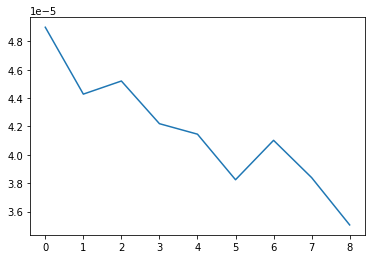

In [61]:
plt.plot(training_loss1, label='training loss')

In [34]:
#torch.save(model, 'model.pt') #uncomment to save new model
the_model = torch.load('model.pt')

In [62]:
torch.manual_seed(0)
# prediction for training set
prediction = []
target = []
permutation = torch.randperm(x_train.size()[0])
for i in tqdm(range(0,x_train.size()[0], batch_size)):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = x_train[indices], y_train[indices].type(torch.float)

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model(batch_x)

    predictions = torch.round(output)
    prediction.append(predictions)
    target.append(batch_y)
    
# training accuracy
accuracy = []
for i in range(len(prediction)):
    accuracy.append(accuracy_score(target[i].cpu(),prediction[i]))
    
print('training accuracy: \t', np.average(accuracy))

100%|██████████| 10/10 [00:04<00:00,  2.05it/s]

training accuracy: 	 1.0


In [63]:
# checking the performance on validation set
torch.manual_seed(0)
output = model(x_test)
criterion(output, y_test)
predictions = torch.round(output)#.type(torch.LongTensor)
accuracy_score(predictions.detach().numpy(), y_test.cpu().detach().numpy())

1.0

In [87]:
import torch
import torchvision
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from skimage import color

box = [330, 190, 660, 355]
box = torch.tensor(box)
box = box.unsqueeze(0)